## IMPORT LIBRARY

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy.stats import skew
from scipy.stats import zscore

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', '{:.3f}'.format)

import warnings
warnings.filterwarnings('ignore')

## LOAD DATASET

In [2]:
# load dataset
df = pd.read_csv('Customer_Segmentation.csv')
df.head(10)

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.075,"1,001.18","1,963.10"
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/18,USD,14,20,196,27,3,0.075,"3,348.66","3,939.60"
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/18,USD,21,16,213,16,1,0.050,781.22,"1,775.50"
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/18,7/6/18,USD,28,48,107,23,8,0.075,"1,464.69","2,324.90"
4,SO - 000105,Distributor,WARE-NMK1003,10/4/18,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.100,"1,476.14","1,822.40"
5,SO - 000106,Online,WARE-PUJ1005,31/12/17,31/5/18,8/6/18,13/6/18,USD,12,21,285,1,5,0.050,446.56,"1,038.50"
6,SO - 000107,In-Store,WARE-XYS1001,31/12/17,31/5/18,8/6/18,14/6/18,USD,10,14,6,5,4,0.150,536.67,"1,192.60"
7,SO - 000108,In-Store,WARE-PUJ1005,10/4/18,31/5/18,26/6/18,1/7/18,USD,6,9,280,46,5,0.050,"1,525.19","1,815.70"
8,SO - 000109,In-Store,WARE-PUJ1005,31/12/17,1/6/18,16/6/18,21/6/18,USD,4,9,299,47,4,0.300,"2,211.20","3,879.30"
9,SO - 000110,In-Store,WARE-UHY1004,31/12/17,1/6/18,29/6/18,1/7/18,USD,10,33,261,13,8,0.050,"1,212.97","1,956.40"


In [3]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderNumber       7991 non-null   object 
 1   Sales Channel     7991 non-null   object 
 2   WarehouseCode     7991 non-null   object 
 3   ProcuredDate      7991 non-null   object 
 4   OrderDate         7991 non-null   object 
 5   ShipDate          7991 non-null   object 
 6   DeliveryDate      7991 non-null   object 
 7   CurrencyCode      7991 non-null   object 
 8   _SalesTeamID      7991 non-null   int64  
 9   _CustomerID       7991 non-null   int64  
 10  _StoreID          7991 non-null   int64  
 11  _ProductID        7991 non-null   int64  
 12  Order Quantity    7991 non-null   int64  
 13  Discount Applied  7991 non-null   float64
 14  Unit Cost         7991 non-null   object 
 15  Unit Price        7991 non-null   object 
dtypes: float64(1), int64(5), object(10)
memory

## DATA PRE-PROCESSING

In [4]:
# The replace() method with regex=True replaces all blank spaces (\s*) with NaN values in the entire DataFrame
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [5]:
# check missing value
df.isnull().sum()

OrderNumber         0
Sales Channel       0
WarehouseCode       0
ProcuredDate        0
OrderDate           0
                   ..
_ProductID          0
Order Quantity      0
Discount Applied    0
Unit Cost           0
Unit Price          0
Length: 16, dtype: int64

In [6]:
# check duplicated
df.duplicated().sum()

0

In [7]:
# convert to datetime in each column
def convert_to_datetime(df, columns):
    for col in columns:
        if col in df.columns and df[col].dtype == 'O':
            df[col] = pd.to_datetime(df[col], errors='coerce')

convert_to_datetime(df, columns=['ProcuredDate', 'OrderDate', 'ShipDate', 'DeliveryDate'])

In [8]:
# remove underscore in each column
def remove_underscore(df, columns):
    for col in columns:
        if col in df.columns:
            df.rename(columns={col: col.replace('_', '')}, inplace=True)

remove_underscore(df, columns=['_SalesTeamID', '_CustomerID', '_StoreID', '_ProductID'])

In [9]:
# convert to float in each column
def convert_to_float(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: float(x.replace(',', '')) if ',' in x else float(x))

convert_to_float(df, columns=['Unit Cost', 'Unit Price'])

In [10]:
# convert to string in each column
def convert_to_string(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str)

convert_to_string(df, columns=['CustomerID', 'ProductID', 'StoreID', 'SalesTeamID'])

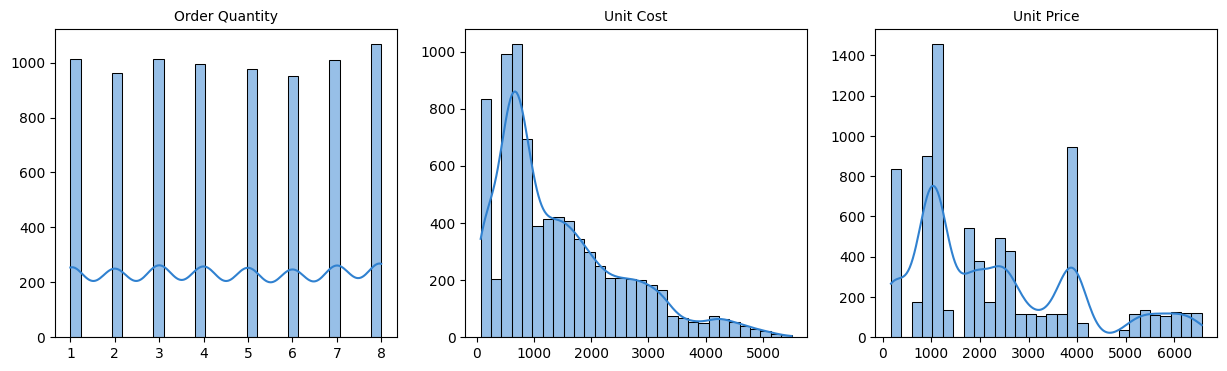

In [11]:
# check outlier using boxplot
cols = ['Order Quantity', 'Unit Cost', 'Unit Price']

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for i, col in enumerate(cols):
    sns.histplot(x=df[col], kde=True, ax=axs[i], color='#3081D0', bins=30)
    axs[i].set_title(col, fontsize=10)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

plt.show()

In [12]:
# create new columns for total cost and total price to calculate the amount of money spent based on the customer's cost and price
df['TotalPrice'] = df['Unit Price'] * df['Order Quantity']
df['TotalPriceDiscount'] = (df['Unit Price'] * df['Order Quantity']) * df['Discount Applied']
df['TotalPurchase'] = df['TotalPrice'] - df['TotalPriceDiscount']

df['TotalCost'] = df['Unit Cost'] * df['Order Quantity']

# calculate total profit based on total price * discount from customers with total cost for product
df['TotalProfit'] = df['TotalPurchase'] - df['TotalCost']

In [13]:
df = df.rename(columns={'Sales Channel': 'SalesChannel',
                        'Order Quantity': 'OrderQuantity',
                        'Discount Applied': 'DiscountApplied',
                        'Unit Cost': 'UnitCost',
                        'Unit Price': 'UnitPrice'})

In [14]:
# sort column names
col_order = ['CustomerID', 'OrderNumber', 'OrderDate', 'ShipDate', 'DeliveryDate', 'ProcuredDate', 'ProductID', 'OrderQuantity', 'DiscountApplied', 'UnitCost', 'UnitPrice', 
             'TotalPrice', 'TotalPriceDiscount', 'TotalPurchase', 'TotalCost', 'TotalProfit', 'CurrencyCode', 'StoreID', 'WarehouseCode', 'SalesTeamID', 'SalesChannel']
df = df[col_order]

In [15]:
df.head(10)

,CustomerID,OrderNumber,OrderDate,ShipDate,DeliveryDate,ProcuredDate,ProductID,OrderQuantity,DiscountApplied,UnitCost,UnitPrice,TotalPrice,TotalPriceDiscount,TotalPurchase,TotalCost,TotalProfit,CurrencyCode,StoreID,WarehouseCode,SalesTeamID,SalesChannel
0,15,SO - 000101,2018-05-31,2018-06-14,2018-06-19,2017-12-31,12,5,0.075,1001.180,1963.100,9815.500,736.163,9079.337,5005.900,4073.438,USD,259,WARE-UHY1004,6,In-Store
1,20,SO - 000102,2018-05-31,2018-06-22,2018-02-07,2017-12-31,27,3,0.075,3348.660,3939.600,11818.800,886.410,10932.390,10045.980,886.410,USD,196,WARE-NMK1003,14,Online
2,16,SO - 000103,2018-05-31,2018-06-21,2018-01-07,2017-12-31,16,1,0.050,781.220,1775.500,1775.500,88.775,1686.725,781.220,905.505,USD,213,WARE-UHY1004,21,Distributor
3,48,SO - 000104,2018-05-31,2018-02-06,2018-07-06,2017-12-31,23,8,0.075,1464.690,2324.900,18599.200,1394.940,17204.260,11717.520,5486.740,USD,107,WARE-NMK1003,28,Wholesale
4,49,SO - 000105,2018-05-31,2018-06-16,2018-06-26,2018-10-04,26,8,0.100,1476.140,1822.400,14579.200,1457.920,13121.280,11809.120,1312.160,USD,111,WARE-NMK1003,22,Distributor
5,21,SO - 000106,2018-05-31,2018-08-06,2018-06-13,2017-12-31,1,5,0.050,446.560,1038.500,5192.500,259.625,4932.875,2232.800,2700.075,USD,285,WARE-PUJ1005,12,Online
6,14,SO - 000107,2018-05-31,2018-08-06,2018-06-14,2017-12-31,5,4,0.150,536.670,1192.600,4770.400,715.560,4054.840,2146.680,1908.160,USD,6,WARE-XYS1001,10,In-Store
7,9,SO - 000108,2018-05-31,2018-06-26,2018-01-07,2018-10-04,46,5,0.050,1525.190,1815.700,9078.500,453.925,8624.575,7625.950,998.625,USD,280,WARE-PUJ1005,6,In-Store
8,9,SO - 000109,2018-01-06,2018-06-16,2018-06-21,2017-12-31,47,4,0.300,2211.200,3879.300,15517.200,4655.160,10862.040,8844.800,2017.240,USD,299,WARE-PUJ1005,4,In-Store
9,33,SO - 000110,2018-01-06,2018-06-29,2018-01-07,2017-12-31,13,8,0.050,1212.970,1956.400,15651.200,782.560,14868.640,9703.760,5164.880,USD,261,WARE-UHY1004,10,In-Store


In [16]:
# dataset information after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CustomerID          7991 non-null   object        
 1   OrderNumber         7991 non-null   object        
 2   OrderDate           7991 non-null   datetime64[ns]
 3   ShipDate            7991 non-null   datetime64[ns]
 4   DeliveryDate        7991 non-null   datetime64[ns]
 5   ProcuredDate        7991 non-null   datetime64[ns]
 6   ProductID           7991 non-null   object        
 7   OrderQuantity       7991 non-null   int64         
 8   DiscountApplied     7991 non-null   float64       
 9   UnitCost            7991 non-null   float64       
 10  UnitPrice           7991 non-null   float64       
 11  TotalPrice          7991 non-null   float64       
 12  TotalPriceDiscount  7991 non-null   float64       
 13  TotalPurchase       7991 non-null   float64     

## EXPLORATORY DATA ANALYSIS

In [17]:
exclude = ['OrderDate', 'ShipDate', 'DeliveryDate', 'ProcuredDate']
df.drop(columns=exclude).describe()

,OrderQuantity,DiscountApplied,UnitCost,UnitPrice,TotalPrice,TotalPriceDiscount,TotalPurchase,TotalCost,TotalProfit
count,7991.000,7991.000,7991.000,7991.000,7991.000,7991.000,7991.000,7991.000,7991.000
mean,4.525,0.114,1431.912,2284.537,10348.233,1195.013,9153.220,6484.554,2668.666
std,2.313,0.086,1112.413,1673.096,10021.420,1768.436,8921.153,6556.446,3416.705
min,1.000,0.050,68.680,167.500,167.500,8.375,100.500,73.700,-12167.200
25%,3.000,0.050,606.120,1031.800,3195.900,257.950,2813.832,1833.920,498.050
50%,5.000,0.075,1080.580,1849.200,6994.800,619.080,6127.820,4206.020,1544.265
75%,7.000,0.150,2040.250,3611.300,14780.200,1421.740,12831.840,8975.860,3522.860
max,8.000,0.400,5498.560,6566.000,52313.600,20818.240,49697.920,42308.080,26384.600


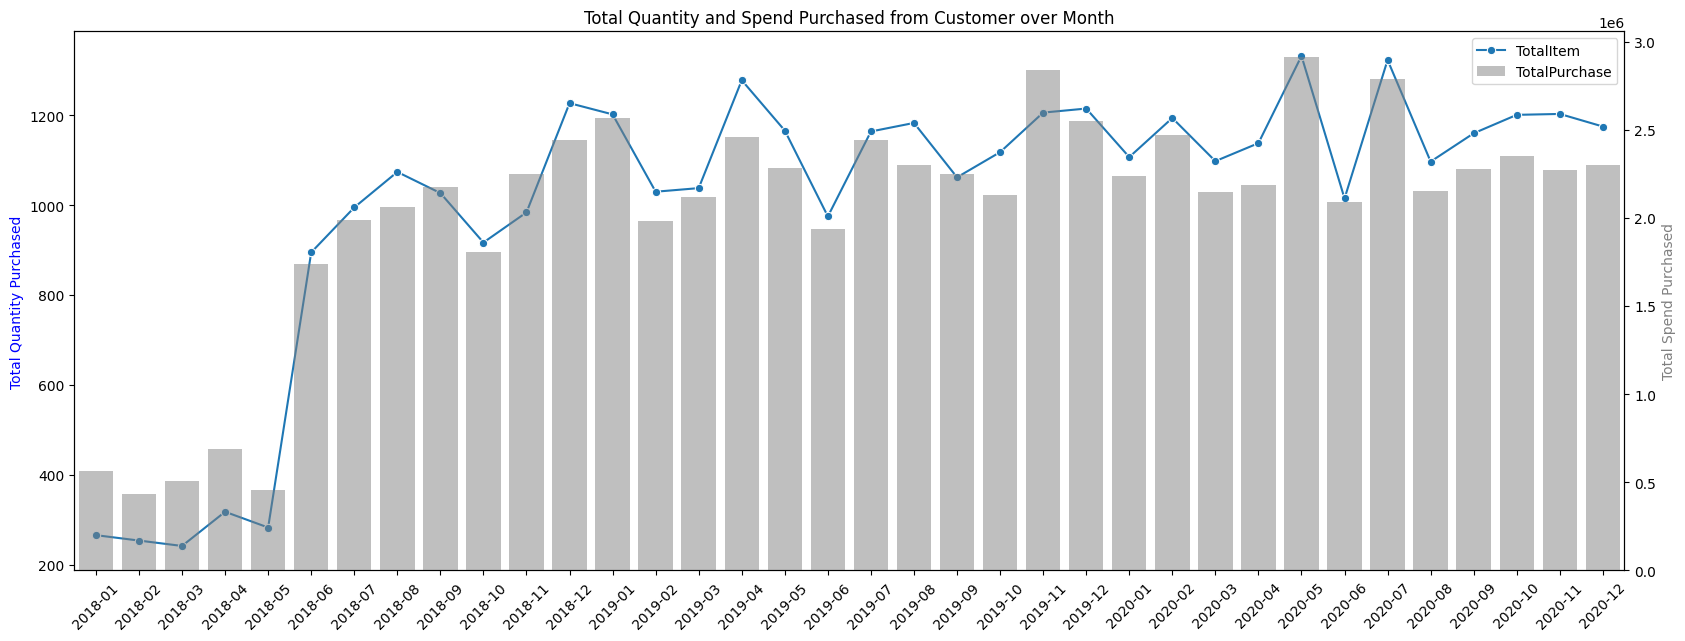

In [18]:
# visualization of total quantity purchased and total spend from customer per month
df['YearMonth'] = df['OrderDate'].dt.to_period('M')
monthly_item_counts = df.groupby('YearMonth')['OrderQuantity'].sum().reset_index(name='TotalItem')
monthly_item_counts['YearMonth'] = monthly_item_counts['YearMonth'].astype(str)

plt.figure(figsize=(20, 7))
ax1 = sns.lineplot(x='YearMonth', y='TotalItem', data=monthly_item_counts, marker='o', label='TotalItem')
ax2 = ax1.twinx()
sns.barplot(x='YearMonth', y='TotalPurchase', data=df.groupby('YearMonth')['TotalPurchase'].sum().reset_index(), ax=ax2, color='gray', 
            alpha=0.5, label='TotalPurchase')

ax1.set_title('Total Quantity and Spend Purchased from Customer over Month')
ax1.set_xlabel('')
ax1.set_ylabel('Total Quantity Purchased', color='blue')
ax2.set_ylabel('Total Spend Purchased', color='gray')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper right')
plt.show()

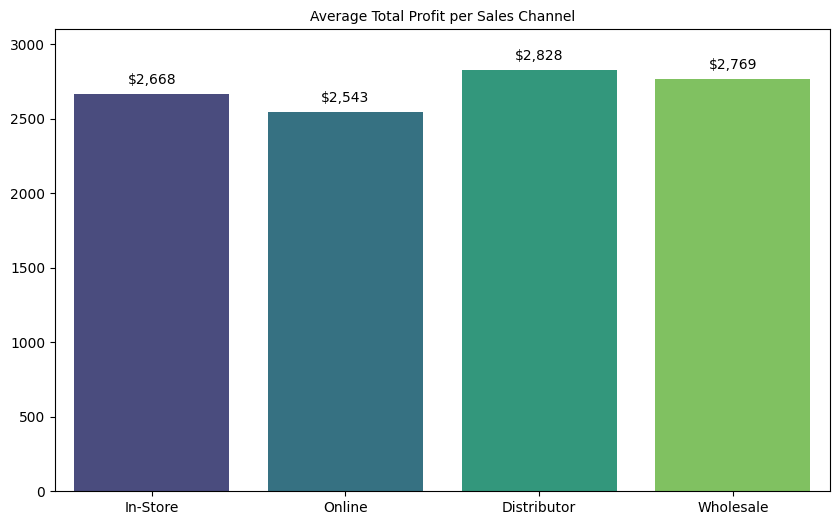

In [19]:
# sales channel based on its average profit
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='SalesChannel', y='TotalProfit', data=df, ci=None, palette='viridis')

for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.ylim(0, + 3100)
plt.title('Average Total Profit per Sales Channel', fontsize=10)
plt.xlabel('')
plt.ylabel('')
plt.show()

## RFM AND CUSTOMER LIFETIME VALUE ANALYSIS

In [20]:
df['FirstPurchase'] = df.groupby('CustomerID')['OrderDate'].transform('min')

rfm = df.groupby('CustomerID', as_index=False).agg(
    Frequency=('OrderNumber', 'nunique'),
    TotalQuantityOrder=('OrderQuantity', 'sum'),
    LastSpending=('OrderDate', 'max'),
    TotalSpending=('TotalPurchase', 'sum'),
    TotalProfit=('TotalProfit', 'sum'),
    FirstPurchase=('FirstPurchase', 'min')
)

last_order = df['OrderDate'].max()

rfm['Recency'] = (last_order - rfm['LastSpending']).dt.days
rfm['Monetary'] = rfm['TotalSpending']

rfm['AverageOrderValue'] = rfm['Monetary'] / rfm['Frequency']
rfm['CustomerLifespan'] = ((last_order - rfm['FirstPurchase']).dt.days / 30)
rfm['PurchaseFrequency'] = rfm['Frequency'] / rfm['CustomerLifespan']

col_order = ['CustomerID', 'FirstPurchase', 'LastSpending', 'CustomerLifespan', 'Recency', 'Frequency', 'PurchaseFrequency', 'TotalQuantityOrder', 'Monetary', 
             'AverageOrderValue', 'TotalProfit']
rfm = rfm[col_order]

rfm['CLV'] = rfm['AverageOrderValue'] * rfm['PurchaseFrequency'] * rfm['CustomerLifespan']
print(rfm.head(10).to_string())

  CustomerID FirstPurchase LastSpending  CustomerLifespan  Recency  Frequency  PurchaseFrequency  TotalQuantityOrder    Monetary  AverageOrderValue  TotalProfit         CLV
0          1    2018-02-07   2020-12-23            35.233        7        152              4.314                 635 1175020.708           7730.399   335933.107 1175020.708
1         10    2018-01-06   2020-12-17            36.300       13        158              4.353                 706 1580759.140          10004.805   435122.000 1580759.140
2         11    2018-01-06   2020-12-26            36.300        4        178              4.904                 805 1658924.857           9319.803   487613.638 1658924.857
3         12    2018-02-11   2020-12-29            35.100        1        210              5.983                 970 2012877.315           9585.130   616719.085 2012877.315
4         13    2018-01-09   2020-12-28            36.200        2        171              4.724                 765 1673217.633       

## PREDICT CUSTOMER SEGMENTATION

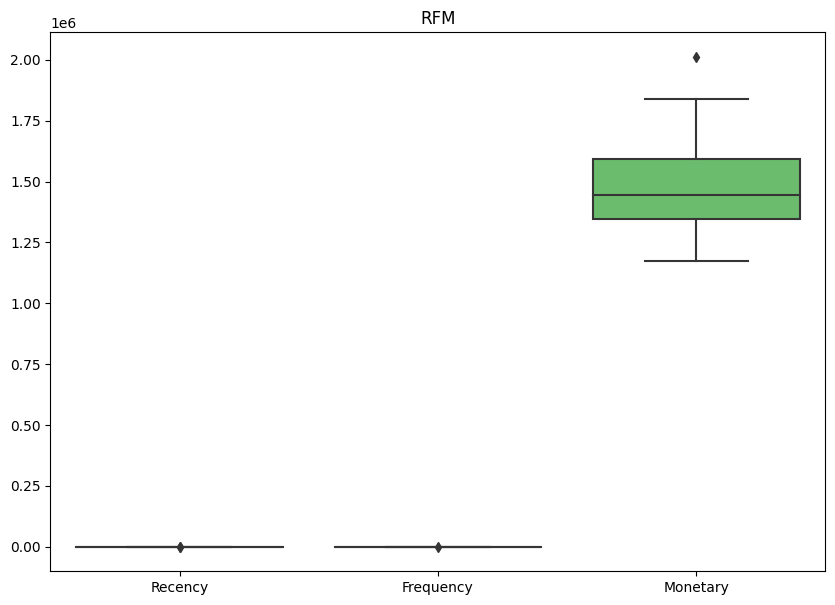

In [21]:
# boxplot for rfm variables
viridis_palette = sns.color_palette('viridis', n_colors=3)
plt.figure(figsize=(10, 7))
sns.boxplot(x='variable', y='value', data=pd.melt(rfm[['Recency', 'Frequency', 'Monetary']]), palette=viridis_palette)
plt.title('RFM')
plt.xlabel('')
plt.ylabel('')
plt.show()

## FEATURE SCALING

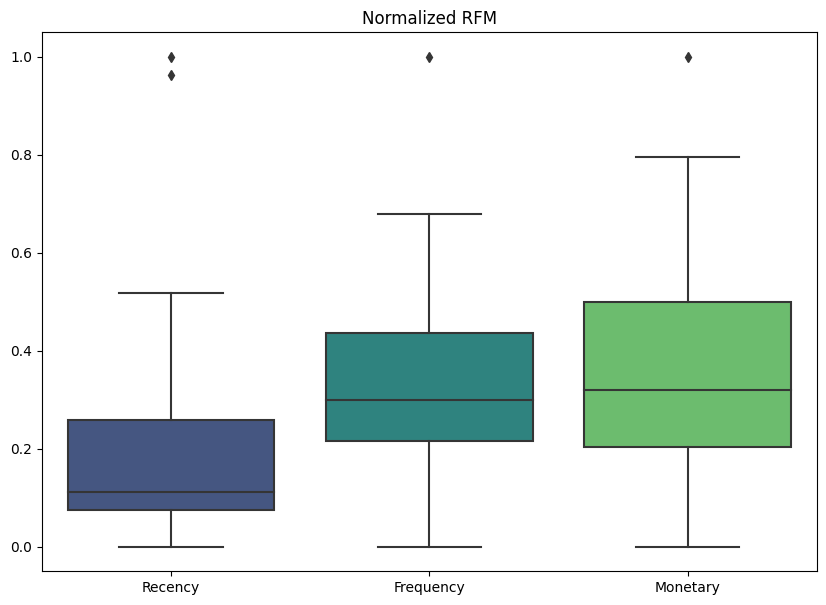

In [22]:
# boxplot for rfm variables after normalization
scaler = MinMaxScaler()
segmentation = rfm[['Recency', 'Frequency', 'Monetary']]
segmentation = scaler.fit_transform(segmentation)
segmentation = pd.DataFrame(segmentation, columns=['Recency', 'Frequency', 'Monetary'])

viridis_palette = sns.color_palette('viridis', n_colors=3)
plt.figure(figsize=(10, 7))
sns.boxplot(x='variable', y='value', data=pd.melt(segmentation), palette=viridis_palette)
plt.title('Normalized RFM')
plt.xlabel('')
plt.ylabel('')
plt.show()

## PRINCIPAL COMPONENT ANALYSIS (PCA)

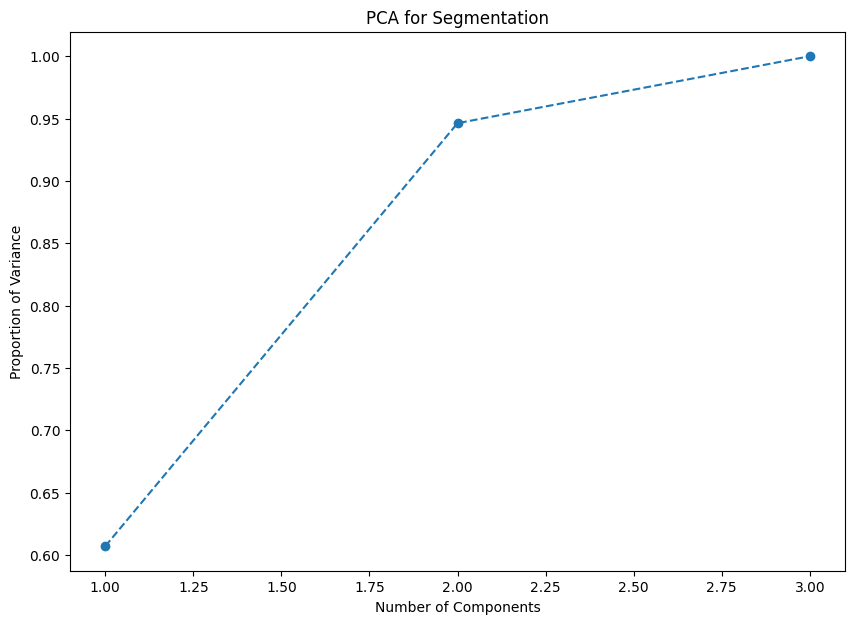

In [23]:
# find the right number of components
pca = PCA()
pca.fit(segmentation)
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.title('PCA for Segmentation', fontsize=12)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance')
plt.show()

In [24]:
# Fit PCA model
pca = PCA(n_components=2)
pca.fit(segmentation)
score_PCA = pca.transform(segmentation)

## CLUSTERING ANALYSIS

## K-MEANS

In [25]:
possible_k_values = range(2, 11)
silhouette_scores_kmeans = []
distortions = []

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(score_PCA)
    labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(score_PCA, labels)
    silhouette_scores_kmeans.append(silhouette_avg)
    
    distortions.append(kmeans.inertia_)

best_indices = sorted(range(len(silhouette_scores_kmeans)), key=lambda i: silhouette_scores_kmeans[i], reverse=True)[:2]
best_clusters = [possible_k_values[i] for i in best_indices]
best_scores = [silhouette_scores_kmeans[i] for i in best_indices]

print(f'The two best clusters are {best_clusters[0]} with silhouette score {best_scores[0]:.4f} and {best_clusters[1]} with silhouette score {best_scores[1]:.4f}')

The two best clusters are 3 with silhouette score 0.4871 and 4 with silhouette score 0.4401


## MODEL EVALUATION

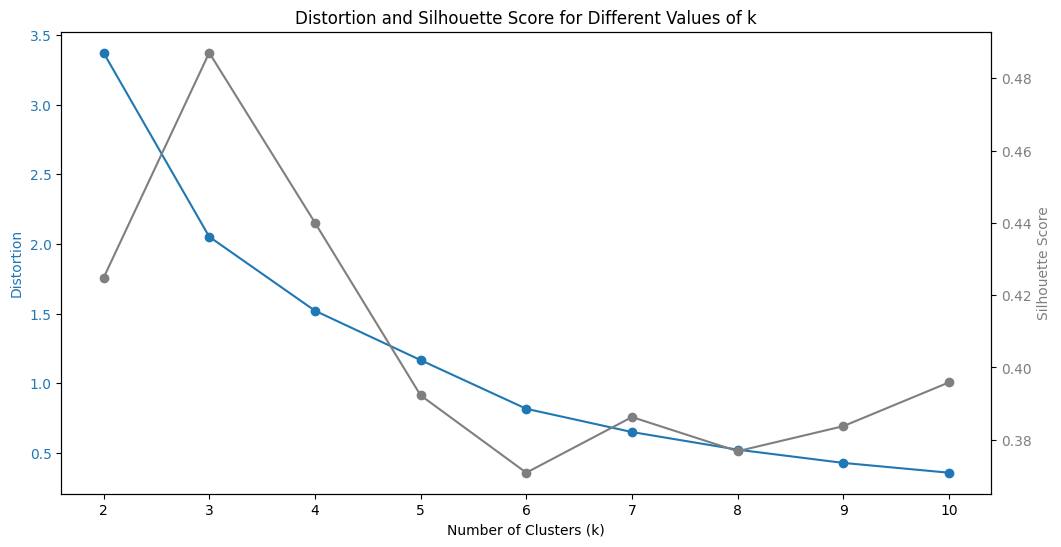

In [26]:
# plotting distortion and silhouette score for different valeues of k
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Distortion', color='tab:blue')
ax1.plot(possible_k_values, distortions, color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:grey')
ax2.plot(possible_k_values, silhouette_scores_kmeans, color='tab:grey', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:grey')

plt.title('Distortion and Silhouette Score for Different Values of k')
plt.show()

In [27]:
# implementation of 3 clusters to dataframe
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(segmentation)
segmentation = segmentation.assign(
    CustomerID=rfm['CustomerID'],
    LastSpending=rfm['LastSpending'],
    cluster=kmeans.labels_
)
segmentation

,Recency,Frequency,Monetary,CustomerID,LastSpending,cluster
0,0.259,0.227,0.000,1,2020-12-23,0
1,0.481,0.307,0.484,10,2020-12-17,1
2,0.148,0.573,0.578,11,2020-12-26,1
3,0.037,1.000,1.000,12,2020-12-29,1
4,0.074,0.480,0.595,13,2020-12-28,1
...,...,...,...,...,...,...
45,0.519,0.373,0.424,50,2020-12-16,1
46,0.074,0.107,0.206,6,2020-12-28,0
47,0.037,0.240,0.255,7,2020-12-29,0
48,0.111,0.093,0.066,8,2020-12-27,0


In [28]:
# average recency, frequency, and monetary of each cluster
mean_rfm = segmentation.groupby('cluster').agg({'Recency': 'mean',
                                                'Frequency': 'mean',
                                                'Monetary': 'mean'})
print(mean_rfm.to_string())

         Recency  Frequency  Monetary
cluster                              
0          0.142      0.216     0.199
1          0.183      0.498     0.561
2          0.981      0.267     0.195


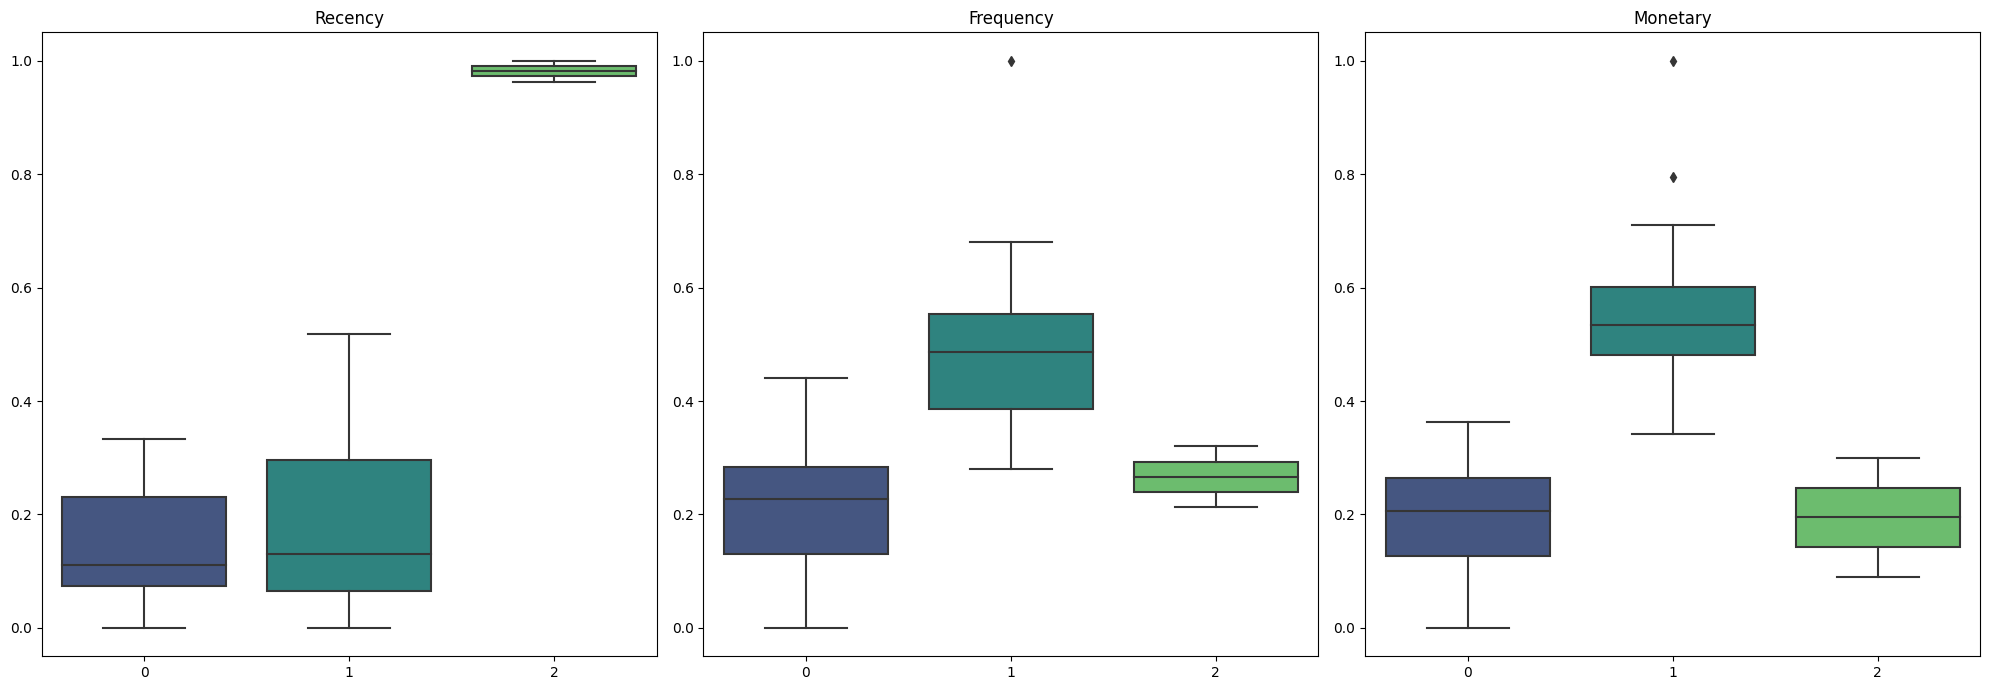

In [29]:
# visualization of each cluster based on RFM analysis using box plot
viridis_palette = sns.color_palette('viridis', n_colors=3)
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
rfm_variables = ['Recency', 'Frequency', 'Monetary']

for i, variable in enumerate(rfm_variables):
    sns.boxplot(x='cluster', y=variable, data=segmentation, ax=axes[i], palette=viridis_palette)
    axes[i].set_title(variable)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

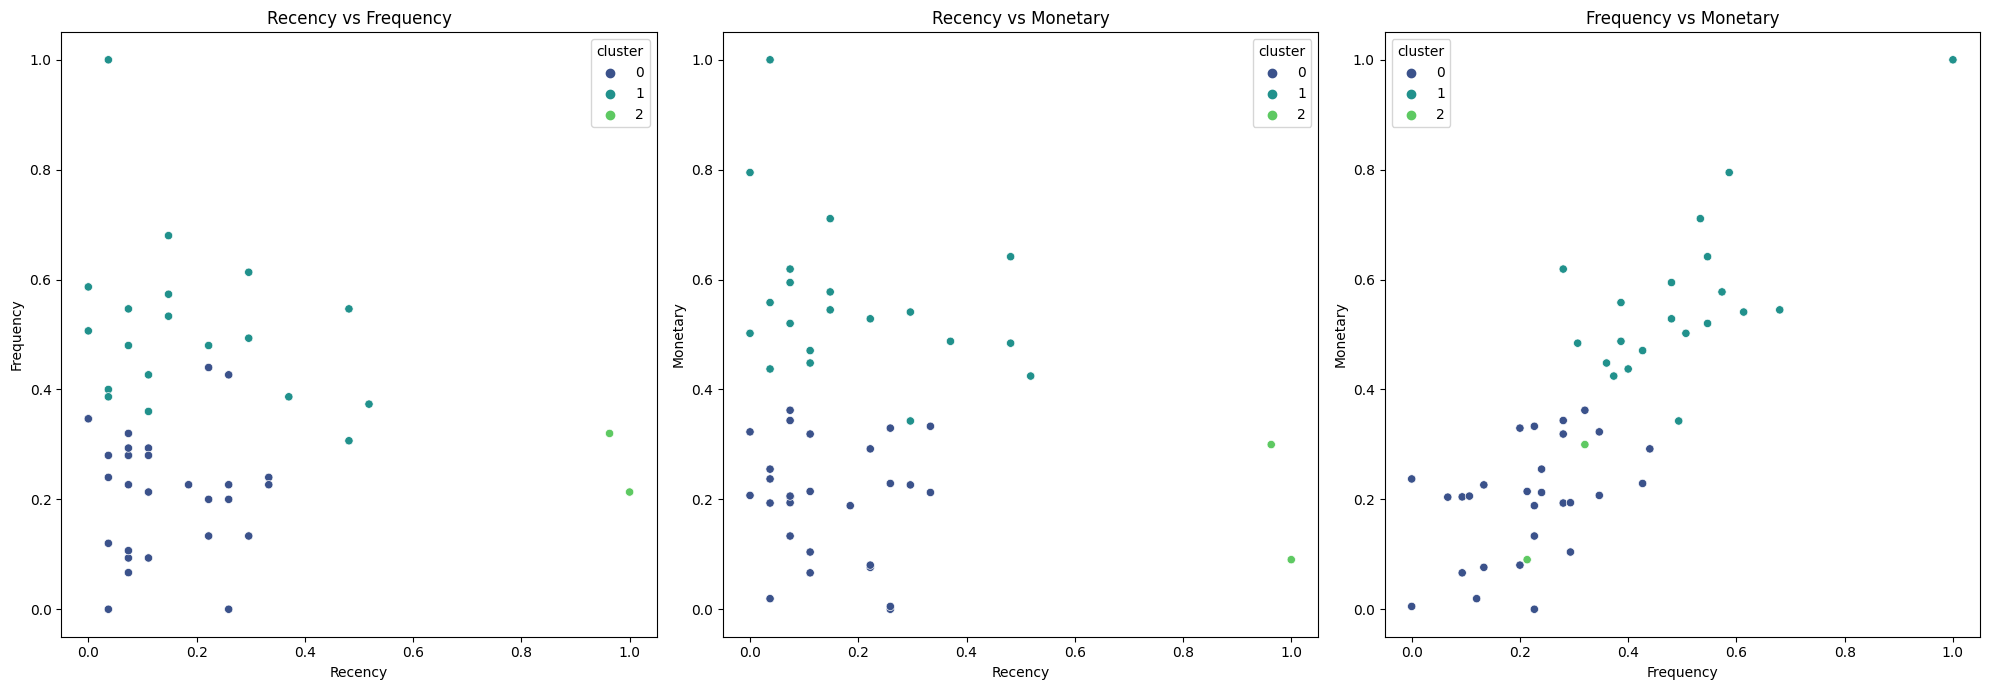

In [30]:
# visualization of each cluster based on RFM analysis using scatter plot
viridis_palette = sns.color_palette('viridis', n_colors=3)
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
scatter_combinations = [('Recency', 'Frequency'), ('Recency', 'Monetary'), ('Frequency', 'Monetary')]

for i, (x_variable, y_variable) in enumerate(scatter_combinations):
    sns.scatterplot(x=x_variable, y=y_variable, hue='cluster', data=segmentation, palette=viridis_palette, ax=axes[i])
    axes[i].set_title(f'{x_variable} vs {y_variable}')

plt.tight_layout()
plt.show()

## PREDICT CUSTOMER LIFETIME VALUE

In [31]:
segmentation.groupby('cluster')['CustomerID'].unique()

cluster
0    [1, 14, 15, 16, 2, 20, 22, 26, 27, 28, 30, 31,...
1    [10, 11, 12, 13, 17, 18, 19, 21, 23, 25, 29, 3...
2                                              [24, 5]
Name: CustomerID, dtype: object

In [32]:
rfm['Cluster'] = None

conditions = [
    rfm['CustomerID'].isin(['24', '5']),
    rfm['CustomerID'].isin(['1', '14', '15', '16', '2', '20', '22', '26', '27', '28', '30', '31', '35', '36', '37', '38', '40', '41', '42', '43', '44', '45', '46', '47', 
                            '49', '6', '7', '8']),
    rfm['CustomerID'].isin(['10', '11', '12', '13', '17', '18', '19', '21', '23', '25', '29', '3', '32', '33', '34', '39', '4', '48', '50', '9'])
]

values = ['Retention Customer', 'Potencial Customer', 'Best Customer']
rfm['Cluster'] = np.select(conditions, values, default=None)

print(rfm.head(10).to_string())

  CustomerID FirstPurchase LastSpending  CustomerLifespan  Recency  Frequency  PurchaseFrequency  TotalQuantityOrder    Monetary  AverageOrderValue  TotalProfit         CLV             Cluster
0          1    2018-02-07   2020-12-23            35.233        7        152              4.314                 635 1175020.708           7730.399   335933.107 1175020.708  Potencial Customer
1         10    2018-01-06   2020-12-17            36.300       13        158              4.353                 706 1580759.140          10004.805   435122.000 1580759.140       Best Customer
2         11    2018-01-06   2020-12-26            36.300        4        178              4.904                 805 1658924.857           9319.803   487613.638 1658924.857       Best Customer
3         12    2018-02-11   2020-12-29            35.100        1        210              5.983                 970 2012877.315           9585.130   616719.085 2012877.315       Best Customer
4         13    2018-01-09   2020-1

In [33]:
df = df[['CustomerID', 'OrderNumber', 'OrderDate', 'ProductID', 'OrderQuantity', 'DiscountApplied', 'UnitCost', 'UnitPrice', 'TotalPrice', 'TotalPriceDiscount', 
         'TotalPurchase', 'TotalCost', 'TotalProfit', 'SalesChannel', 'YearMonth', 'FirstPurchase']].merge(
     rfm[['CustomerID', 'LastSpending', 'CustomerLifespan', 'Recency', 'Frequency', 'PurchaseFrequency', 'TotalQuantityOrder', 'Monetary', 'AverageOrderValue',
          'CLV', 'Cluster']],
     on='CustomerID', how='left')

In [34]:
df.head(10)

,CustomerID,OrderNumber,OrderDate,ProductID,OrderQuantity,DiscountApplied,UnitCost,UnitPrice,TotalPrice,TotalPriceDiscount,TotalPurchase,TotalCost,TotalProfit,SalesChannel,YearMonth,FirstPurchase,LastSpending,CustomerLifespan,Recency,Frequency,PurchaseFrequency,TotalQuantityOrder,Monetary,AverageOrderValue,CLV,Cluster
0,15,SO - 000101,2018-05-31,12,5,0.075,1001.180,1963.100,9815.500,736.163,9079.337,5005.900,4073.438,In-Store,2018-05,2018-01-11,2020-12-28,36.133,2,142,3.930,627,1346355.955,9481.380,1346355.955,Potencial Customer
1,20,SO - 000102,2018-05-31,27,3,0.075,3348.660,3939.600,11818.800,886.410,10932.390,10045.980,886.410,Online,2018-05,2018-01-09,2020-12-23,36.200,7,167,4.613,754,1366847.570,8184.716,1366847.570,Potencial Customer
2,16,SO - 000103,2018-05-31,16,1,0.050,781.220,1775.500,1775.500,88.775,1686.725,781.220,905.505,Distributor,2018-05,2018-04-08,2020-12-29,33.233,1,135,4.062,630,1373728.302,10175.765,1373728.303,Potencial Customer
3,48,SO - 000104,2018-05-31,23,8,0.075,1464.690,2324.900,18599.200,1394.940,17204.260,11717.520,5486.740,Wholesale,2018-05,2018-01-07,2020-12-22,36.267,8,172,4.743,783,1462124.250,8500.722,1462124.250,Best Customer
4,49,SO - 000105,2018-05-31,26,8,0.100,1476.140,1822.400,14579.200,1457.920,13121.280,11809.120,1312.160,Distributor,2018-05,2018-01-11,2020-12-25,36.133,5,152,4.207,653,1332987.445,8769.654,1332987.445,Potencial Customer
5,21,SO - 000106,2018-05-31,1,5,0.050,446.560,1038.500,5192.500,259.625,4932.875,2232.800,2700.075,Online,2018-05,2018-01-06,2020-12-29,36.300,1,164,4.518,778,1642714.877,10016.554,1642714.877,Best Customer
6,14,SO - 000107,2018-05-31,5,4,0.150,536.670,1192.600,4770.400,715.560,4054.840,2146.680,1908.160,In-Store,2018-05,2018-01-11,2020-12-27,36.133,3,157,4.345,681,1262274.640,8039.966,1262274.640,Potencial Customer
7,9,SO - 000108,2018-05-31,46,5,0.050,1525.190,1815.700,9078.500,453.925,8624.575,7625.950,998.625,In-Store,2018-05,2018-01-06,2020-12-24,36.300,6,171,4.711,818,1617932.415,9461.593,1617932.415,Best Customer
8,9,SO - 000109,2018-01-06,47,4,0.300,2211.200,3879.300,15517.200,4655.160,10862.040,8844.800,2017.240,In-Store,2018-01,2018-01-06,2020-12-24,36.300,6,171,4.711,818,1617932.415,9461.593,1617932.415,Best Customer
9,33,SO - 000110,2018-01-06,13,8,0.050,1212.970,1956.400,15651.200,782.560,14868.640,9703.760,5164.880,In-Store,2018-01,2018-01-06,2020-12-28,36.300,2,156,4.298,767,1693781.942,10857.577,1693781.942,Best Customer


In [35]:
df.drop(columns='YearMonth', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CustomerID          7991 non-null   object        
 1   OrderNumber         7991 non-null   object        
 2   OrderDate           7991 non-null   datetime64[ns]
 3   ProductID           7991 non-null   object        
 4   OrderQuantity       7991 non-null   int64         
 5   DiscountApplied     7991 non-null   float64       
 6   UnitCost            7991 non-null   float64       
 7   UnitPrice           7991 non-null   float64       
 8   TotalPrice          7991 non-null   float64       
 9   TotalPriceDiscount  7991 non-null   float64       
 10  TotalPurchase       7991 non-null   float64       
 11  TotalCost           7991 non-null   float64       
 12  TotalProfit         7991 non-null   float64       
 13  SalesChannel        7991 non-null   object      

## BUSINESS SIMULATION AND RECOMMENDATION FOR EACH SEGMENTATION

In [36]:
print('''
Cluster 0: Potencial Customer
Customers in this cluster have low Recency, low Frequency, and low Monetary values
      
- Maintain healthy communication and engagement with customers in this cluster
- Explore ways to increase their purchase frequency and monetary value
- Offer incentives or promotions to stimulate additional purchases
      
Cluster 1: Best Customer
Customers in this cluster have low Recency, high Frequency, and high Monetary values
      
- Focus on maintaining and improving customer satisfaction in this cluster
- Offer incentives or loyalty programs to encourage further purchases
- Conduct customer satisfaction surveys to understand their needs and preferences
      
Cluster 2: Retention Customer
Customers in this cluster have high Recency, medium Frequency, and medium Monetary value

- Implement a customer retention strategy to reduce Recency value
- Provide special incentives or discounts to reactivate customers in this cluster
- Monitor customer behavior to identify changes and respond quickly
      ''')


Cluster 0: Potencial Customer
Customers in this cluster have low Recency, low Frequency, and low Monetary values
      
- Maintain healthy communication and engagement with customers in this cluster
- Explore ways to increase their purchase frequency and monetary value
- Offer incentives or promotions to stimulate additional purchases
      
Cluster 1: Best Customer
Customers in this cluster have low Recency, high Frequency, and high Monetary values
      
- Focus on maintaining and improving customer satisfaction in this cluster
- Offer incentives or loyalty programs to encourage further purchases
- Conduct customer satisfaction surveys to understand their needs and preferences
      
Cluster 2: Retention Customer
Customers in this cluster have high Recency, medium Frequency, and medium Monetary value

- Implement a customer retention strategy to reduce Recency value
- Provide special incentives or discounts to reactivate customers in this cluster
- Monitor customer behavior to ident

## IMPORT TO POSTGRESQL

In [37]:
from sqlalchemy import create_engine

db_config = {
    'host': 'localhost',
    'port': '5432',
    'database': 'Project',
    'user': 'postgres',
    'password': 'nauraraniyah23'
}

engine = create_engine(f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

nama_tabel = 'CustomerSegmentation'
df.to_sql(nama_tabel, engine, if_exists='replace', index=False)

991